# SPAMSの紹介

## 1. 概要

[SPAMS](http://spams-devel.gforge.inria.fr/index.html) (SPArse Modeling Software) はさまざまなスパース正則化手法をまとめたライブラリで、Julien Mairal氏 (Inria) らによって開発されています。

コア部分はC++で書かれており、Matlab, R, Python2, Python3のインターフェースが利用できます。

## 2. 主な機能

1. 辞書学習 (dictionary learning)、スパース行列分解 (NMF, sparse PCA, etc.)
1. 構造的スパース正則化の近接作用素の計算 (L1, L2, group lasso, 階層lasso)
1. スパース線形回帰 (LARS,coordinate descent, OMP)

特に、辞書学習と、maxflowを利用した珍しい近接作用素の計算がウリです。

## 3. 実行環境の構築

ここでは、SPAMS v2.6.1をPython3.5.2から利用します。

### 3.1. 事前準備

SPAMSの外部モジュールがC++で書かれているため、ビルドできる環境が必要になります。Ubuntuでは以下のように用意します。

```
$ sudo apt-get install build-essential python3-dev libblas-dev liblapack-dev
```

注意点として、MacOSではビルドすることができません。公式ページにも注意があるとおり、MacOS版のclangがOpenMPに対応していないためです。
（このnotebook自体は、MacOSからUbuntu16.04の仮想環境を立ち上げて動作を確認しています。）

### 3.2. SPAMSのインストール

[公式サイト](http://spams-devel.gforge.inria.fr/downloads.html)からv2.6.1をダウンロードします。

setupスクリプトで以下のようにしてインストールできます。

```
$ cd path/to/spams-2.6.1
$ python setup.py build
$ python setup.py install
```

## 4. スパース線形回帰

動作確認のため、SPAMSを利用してスパース線形回帰の問題を解きます。なお、この問題に関しては、ほぼ同じことができる `sklearn.linear_model.Lasso` と比較して使い勝手は良くないです。

$y$を$n$次元の観測ベクトル、$X$を与えられた$n \times p$行列とするとき、$y \approx X\beta$を満たす$\beta$を計算します。ここで、$\beta$はスパースになるように計算されます。

| 数式 | ライブラリ内の記号 |
| --- | -------------- |
| $X$ | D |
| $y$ | X |
| $\beta$ | A |
| $X^\top X$ | Q |
| $X^\top y$ | q |

### 4.1. Lasso / Elastic Net

`spams.lasso`は
$$
\min_{\beta \in \mathbb{R}^p} \quad \frac{1}{2} \lVert y - X\beta \rVert_2^2
+ \lambda_1 \lVert \beta \rVert_1
$$
あるいは
$$
\min_{\beta \in \mathbb{R}^p} \quad \frac{1}{2} \lVert y - X\beta \rVert_2^2
\quad \text{s.t.} \quad \lVert \beta \rVert_1 \leq \lambda_1
$$
をLARSアルゴリズムによって計算します （定式化はmodeで選べます）。また、L2正則化項を足してElastic Netの解も計算できます。

* 同じ問題をcoordinate descentで解く`spams.cd`も用意されていますが、手元の環境ではうまく動きませんでした

In [1]:
# LARS

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import spams

diabetes = datasets.load_diabetes()
X = np.asfortranarray(diabetes.data, dtype=np.float64)
X /= X.std(axis=0)
y = np.asfortranarray([diabetes.target], dtype=np.float64).T

# Lassoで意味のあるlambdaの最大値は X^\top yのsupノルムをnで割ったもの
lambda_max = np.max(np.abs(np.dot(X.T, y))) / y.shape[0]

# homotopy-LARSアルゴリズムによってlambda1で指定したパラメータまでのパスを計算する
# pathには「折れ目」ごとの値が格納されるため、実際の正則化パラメータとの対応は取得できない模様
(beta, path) = spams.lasso(y, D=X, return_reg_path=True, lambda1=lambda_max, max_length_path=15)

print('beta: ', beta) #スパース行列として出力
print('path.shape: ', path.shape)

tol = 1e-10
path_length = np.max(np.where(np.linalg.norm(path, axis=0) > tol)[0])

fig, ax = plt.subplots()
ax.plot(np.arange(path_length), (path.T)[:path_length])
plt.show()

beta:    (0, 0)	-0.2744343613083767
  (1, 0)	-11.15420266734892
  (2, 0)	24.85693075717076
  (3, 0)	15.23939303705943
  (4, 0)	-26.412604608902335
  (5, 0)	13.689272427832071
  (7, 0)	7.06559621881766
  (8, 0)	31.559491925335582
  (9, 0)	3.156625192910148
path.shape:  (10, 15)


<Figure size 640x480 with 1 Axes>

## 4.2. Orthogonal Matching Pursuit (forward selection)

L0正則化に相当する問題をgreedyに解きます。

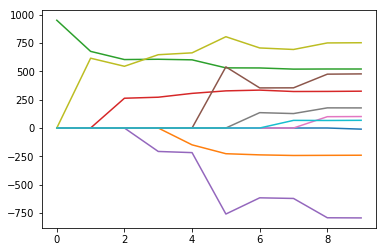

In [2]:
# OMP

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import spams

diabetes = datasets.load_diabetes()
X = np.asfortranarray(diabetes.data, dtype=np.float64)
X = np.asfortranarray(X / np.tile(np.sqrt((X*X).sum(axis=0)),(X.shape[0],1)),dtype=np.float64)
#X /= X.std(axis=0)
y = np.asfortranarray([diabetes.target], dtype=np.float64).T

lambda_max = np.max(np.abs(np.dot(X.T, y))) / y.shape[0]

(beta, path) = spams.omp(y, X, return_reg_path=True, lambda1=lambda_max)

fig, ax = plt.subplots()
ax.plot(np.arange(path.shape[1]), path.T)
plt.show()

# 5. 近接作用素の計算

$\Omega: \mathbb{R}^p \to \mathbb{R}^p$ の近接作用素 (proximal operator) は、
$$
\mathrm{prox}_{\Omega}(x) = \arg \min_{z \in \mathbb{R}^p} \frac{1}{2} \lVert x - z \rVert_2^2 + \Omega(z)
$$
で定義されます。使い道としては、
$$
\min_{x \in \mathbb{R}^p} f(x) + \lambda \Omega(x)
$$
のような最適化問題を近接勾配法 (ISTA, FISTA) で解くときなどに利用できます。

SPAMSでは、以下の関数の近接作用素が計算できます。簡単に実装できるものもありますが、 (*) がついているものは実装方法がそれなりに非自明と思われます。

- $\ell_2$ ノルム
- $\ell_1$ ノルム
- Elastic Net型正則化 ($\ell_1 + \ell_2$)
- (*) Fused lasso $$\Omega(x) = \sum_{i=1}^{p-1} |x_i - x_{i + 1}|$$
- $\ell_q$ group lasso ($q = 2, \infty$): $$\Omega(x) = \sum_{g \in G} w_g \lVert x_g \rVert_q$$ ここで $G$ は添字の分割
- (*) 階層構造Lasso ($q = 2, \infty$): $$\Omega(x) = \sum_{g \in G} w_g \lVert x_g \rVert_q$$ ここで $G$ は階層的グループ (i.e. 包含で木構造が入るもの)
- (*) General sum of $\ell_\infty$-norms: $$\Omega(x) = \sum_{g \in G} w_g \lVert x_g \rVert_\infty$$ ここで、$G$ は添字の部分集合の族だが、分割になっているとは限らない

また、行列変数の近接作用素もいくつか実装されています (trace norm, multi-task treeなど)

## 5.1. Fused lasso

注： おそらく正しく動いていない！

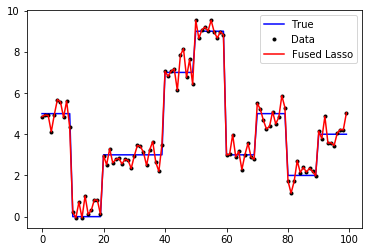

In [3]:
# 例: Fused lasso

import numpy as np
import matplotlib.pyplot as plt
import spams

np.random.seed(0)

# data generation
n = 100
sigma = 0.5
k = 10
theta = np.random.randint(k, size=k).repeat(int(n/k))
y = theta + sigma * np.random.randn(n)

# fused lasso
# regulに正則化項の名前を指定することで色々な近接作用素が計算できる。
# 使える名前一覧はドキュメント参照： http://spams-devel.gforge.inria.fr/doc-python/html/doc_spams006.html
param = {
    'return_val_loss': False,
    'numThreads': -1,
    'regul': 'fused-lasso',
    'lambda1': 5.0, # total variationの係数
    'lambda2': 0.0, # L1正則化
    'lambda3': 0.0, # L2正則化
}
Y = np.asfortranarray([y], dtype=np.float64)
theta_hat = spams.proximalFlat(Y, **param)

fig, ax = plt.subplots()
ax.plot(np.arange(n), theta, 'b-', label='True')
ax.plot(np.arange(n), y, 'k.', label='Data')
ax.plot(np.arange(n), theta_hat[0, :], 'r-', label='Fused Lasso')
ax.legend()
plt.show()